In [17]:
import pandas as pd
import os
import seaborn as sns
import xarray as xr
import numpy as np
import re
from datetime import datetime
import netCDF4 as nc
from numpy_groupies.aggregate_numba import aggregate
import numpy_groupies as npg
import matplotlib.pyplot as plt

start = "/Users/caropark/Dropbox (Harvard University)/DataByCountry/United States of America"

In [18]:
def clean_masked_cal():
    
    key = pd.read_pickle("./data/calendar_fao_cropkey.pkl")
    idx = np.unique(key['harv_area_idx'].values)

    end_harvarea = "/harvest_area_fraction_data_sage_all.nc"
    harvarea = xr.open_dataset(start+end_harvarea)['harvest_area_frac_nearest']
    harvarea['location']= harvarea['location']+0
    harvarea['crop'] = harvarea['crop']+0
    harvarea = harvarea.sel(crop=idx).where(harvarea>0)

    counts = harvarea.groupby('crop').count(...)
    counts = counts.where(counts>0, drop=True)['crop'].values
    wanted = key[key['harv_area_idx'].isin(counts)]['crop'].values
    harvarea = harvarea.rename({"crop": "harv_area_idx"})
    harvarea = harvarea.where(harvarea.harv_area_idx.isin(counts), drop=True)

    harvarea = harvarea.to_dataframe().reset_index().merge(key[["crop", 'harv_area_idx']], how="left").set_index(['crop', 'location']).to_xarray()
    harvarea['location']= harvarea['location']+0
    harvarea['crop'] = harvarea['crop']+0

    end_cal = '/crop_calendar_data_sage.nc'
    end_harvarea = "/harvest_area_fraction_data_sage_all.nc"

    calendar = xr.open_dataset(start+end_cal)
    calendar['location'] = calendar['location']+0
    calendar['crop']= calendar['crop']+0

    xry = harvarea.merge(calendar, join="left")[["plant", "harvest", "harvest_area_frac_nearest"]]
    xry['plant']= np.ceil(xry['plant']).astype(int)
    xry['harvest']= np.ceil(xry['harvest']).astype(int)
    xry = xry.where(xry != 0)
    xry['plant']= (np.datetime64("1999-12-31") + xry['plant'].astype("timedelta64[D]")).dt.month
    xry['harvest']= (np.datetime64("1999-12-31") + xry['harvest'].astype("timedelta64[D]")).dt.month
    xry['plant']= xr.where(xry['harvest'] < xry['plant'], xry.plant-12, xry.plant)
    xry = xry.where(xry['harvest_area_frac_nearest'].notnull(), drop=True)

    return(harvarea, xry)

In [19]:
def get_growing_szn(xry):
    xry = xry.where(xry['plant'].notnull(), drop=True)
    xry_df = xry.to_dataframe().reset_index() 

    plant = xry['plant'].values.flatten()
    harvest = xry['harvest'].values.flatten()

    def unique_pairs(a, b):
        c = np.sort(np.stack([a, b], axis = 1), axis = 1)
        c_view = np.ascontiguousarray(c).view(np.dtype((np.void,
                                              c.dtype.itemsize * c.shape[1])))
        _, i = np.unique(c_view, return_index = True)
        return a[i].astype(np.int64), b[i].astype(np.int64)

    heya = unique_pairs(plant, harvest)
    lst = [list(range(i, j+1)) for i, j in zip(heya[0], heya[1])]

    if 0 in lst:
        lst.remove([0])

    growszn = pd.DataFrame({'month':lst,
                 'plant': [xi[0] for xi in lst],
                 'harvest': [xi[-1] for xi in lst],
                           'growing': 1}).explode('month')

    ok = xry_df.merge(growszn, how="left").set_index(['month', 'location', 'crop']).to_xarray()
    growmonths = ok.where(ok['growing']>0, drop=True)
    
    return(growmonths)

In [20]:
def merge_sif(growmonths):
    end_fao = '/fao_data.nc'
    end_sif = '/csif_data.nc'
    fao = xr.open_dataset(start+end_fao, drop_variables="crop")
    sif = xr.open_dataset(start+end_sif)
    sif['location']= sif['location']+0
    sif = sif.where(sif['csif']>0) 
    sif['month']= sif['month']+1
    sif_shift = sif.copy().shift(year=1)
    sif_shift['month'] = sif_shift['month']-12
    sif_comb = xr.merge([sif, sif_shift])
    
    sifmerged = xr.merge([growmonths, sif_comb], join="left")
    
    return(sifmerged)

In [21]:
def sifmeans_n_fao(sifmerged):
    test = sifmerged[['csif', 'harvest_area_frac_nearest']].where(sifmerged['plant'].notnull(), drop=True).stack(hello=('crop', 'year'))
    test['harvest_area_frac_nearest']= test['harvest_area_frac_nearest'].fillna(0)
    test['csif_w']= test['csif'].weighted(test['harvest_area_frac_nearest']).mean(["month", "location"])
    
    sifvals= test['csif'].values
    sifvals = sifvals.reshape(sifvals.shape[0]*sifvals.shape[1], sifvals.shape[2])
    gridcells = ((~np.isnan(sifvals)) & (sifvals>0)).sum(0)

    df = test['csif_w'].to_dataframe().reset_index(drop=True)
    df['gridcells'] = gridcells

    end_fao = '/fao_data.nc'
    fao = xr.open_dataset(start+end_fao, drop_variables="crop")
    fao_yield = fao.sel(year=slice(2000,2020))[['yield']]
    faoy = fao_yield.to_dataframe().reset_index().rename({"crop": "fao_idx"}, axis=1)
    key = pd.read_pickle("./data/calendar_fao_cropkey.pkl")
    faoy = faoy.merge(key, how="left").dropna()
    df = df.merge(faoy, how="left").reset_index(drop=True)
    df = df[df['yield'].notna()]
    df = df[df['gridcells']>0]
    
    return(df)

In [22]:
def avg_2crops_n_lags(df):
    grids = df.groupby(['year', 'fao_idx', 'cropname', 'yield'])['gridcells'].sum('gridcells').reset_index()
    test = df.groupby(['year', 'fao_idx', 'cropname', 'yield']).apply(lambda x: np.average(x['csif_w'], weights=x['gridcells'])).reset_index().rename({0:"csif"}, axis=1)
    test['country'] = start.rsplit('/',1)[1]
    ugh = test.merge(grids, how="left")

    ugh['yield_lag'] = ugh.groupby('cropname')['yield'].shift(1)
    ugh['yield_lead'] = ugh.groupby('cropname')['yield'].shift(-1)
    corrs = ugh.groupby('cropname')[['yield', 'yield_lag', 'yield_lead']].corrwith(ugh['csif'])
    corrs = corrs.idxmax(axis=1).to_frame().reset_index()
    corrs.columns=["cropname", "whichlag"]

    ugh = ugh.merge(corrs)
    ugh['name'] = np.where(ugh.whichlag == "yield", ugh.country, ugh.country + " (" + (ugh.whichlag).str.replace("yield_", "") + ")")

    return(ugh)

In [23]:
def plotme(ugh, cropname):
    ugh= ugh[(ugh['cropname']==str(cropname))]
    
    idx, cols = pd.factorize(ugh['whichlag'])
    ugh['yield'] = ugh.reindex(cols, axis=1).to_numpy()[np.arange(len(ugh)), idx]

    def twin_lineplot(x,y,color,**kwargs):
        ax = plt.twinx()
        sns.lineplot(x=x,y=y,color=color, ax=ax)
        ax.set_ylabel(cropname + " FAO yield")

    g = sns.FacetGrid(ugh, col="name",  height=4, aspect=1.5)
    g.map(sns.lineplot, "year", "csif", color="red", ci=None)

    for ax in g.axes.flat:
        ax.set_ylabel("Season-averaged SIF", color="red")
        ax.tick_params(axis='y', colors='red')

    g.map(twin_lineplot, 'year', 'yield', color="black")
    g.set_axis_labels("Year", "Season-averaged SIF")
    g.set_titles(col_template='{col_name}')
    plt.show()
#    os.system('say "done"')

In [24]:
def plotme_facet(ugh):
    idx, cols = pd.factorize(ugh['whichlag'])
    ugh['yield'] = ugh.reindex(cols, axis=1).to_numpy()[np.arange(len(ugh)), idx]
    cropnum = len(np.unique(ugh['cropname']))

    colors = ["blue", "green", "red", "orange", "#98ff98", 
          "#eac736", "#d0aaf3", "pink", "#c0ebe7", "brown",
          "#cbbeb5", "#aa629c", "#b0bf1a", "#ff00ff", "#9bd18c",
         "#2acaea"]

    def twin_lineplot(x,y,color,**kwargs):
        ax = plt.twinx()
        sns.lineplot(x=x,y=y,color=color, ax=ax)
        ax.set_ylabel("FAO yield")

    g = sns.FacetGrid(ugh, col="cropname",hue="cropname", col_wrap=5, height=4, aspect=1.5, sharey=False, palette= colors)#sns.color_palette("hls", cropnum))
    g.map(sns.lineplot, "year", "csif", ci=None, lw=4)

    for ax in g.axes.flat:
        ax.set_ylabel("Season-averaged SIF", color='red')
        ax.tick_params(axis='y', colors='red')

    g.map(twin_lineplot, 'year', 'yield', color="black")
    g.set_axis_labels("Year", "Season-averaged SIF")
    g.set_titles(col_template='{col_name}', size=20)
    plt.show()
    os.system('say "done"')

In [25]:
%time
harvarea, xry = clean_masked_cal()

%time
growmonths = get_growing_szn(xry)

%time
sifmerged = merge_sif(growmonths)

%time
df = sifmeans_n_fao(sifmerged)

%time
ugh = avg_2crops_n_lags(df)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
CPU times: user 1 µs, sys: 12 µs, total: 13 µs
Wall time: 21 µs
CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 160 µs
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


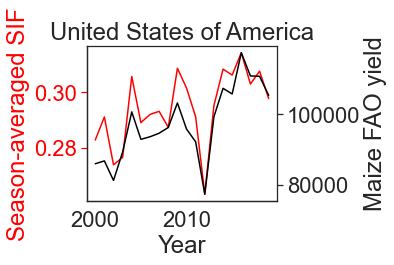

In [26]:
plotme(ugh, "Maize")

In [27]:
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 22})

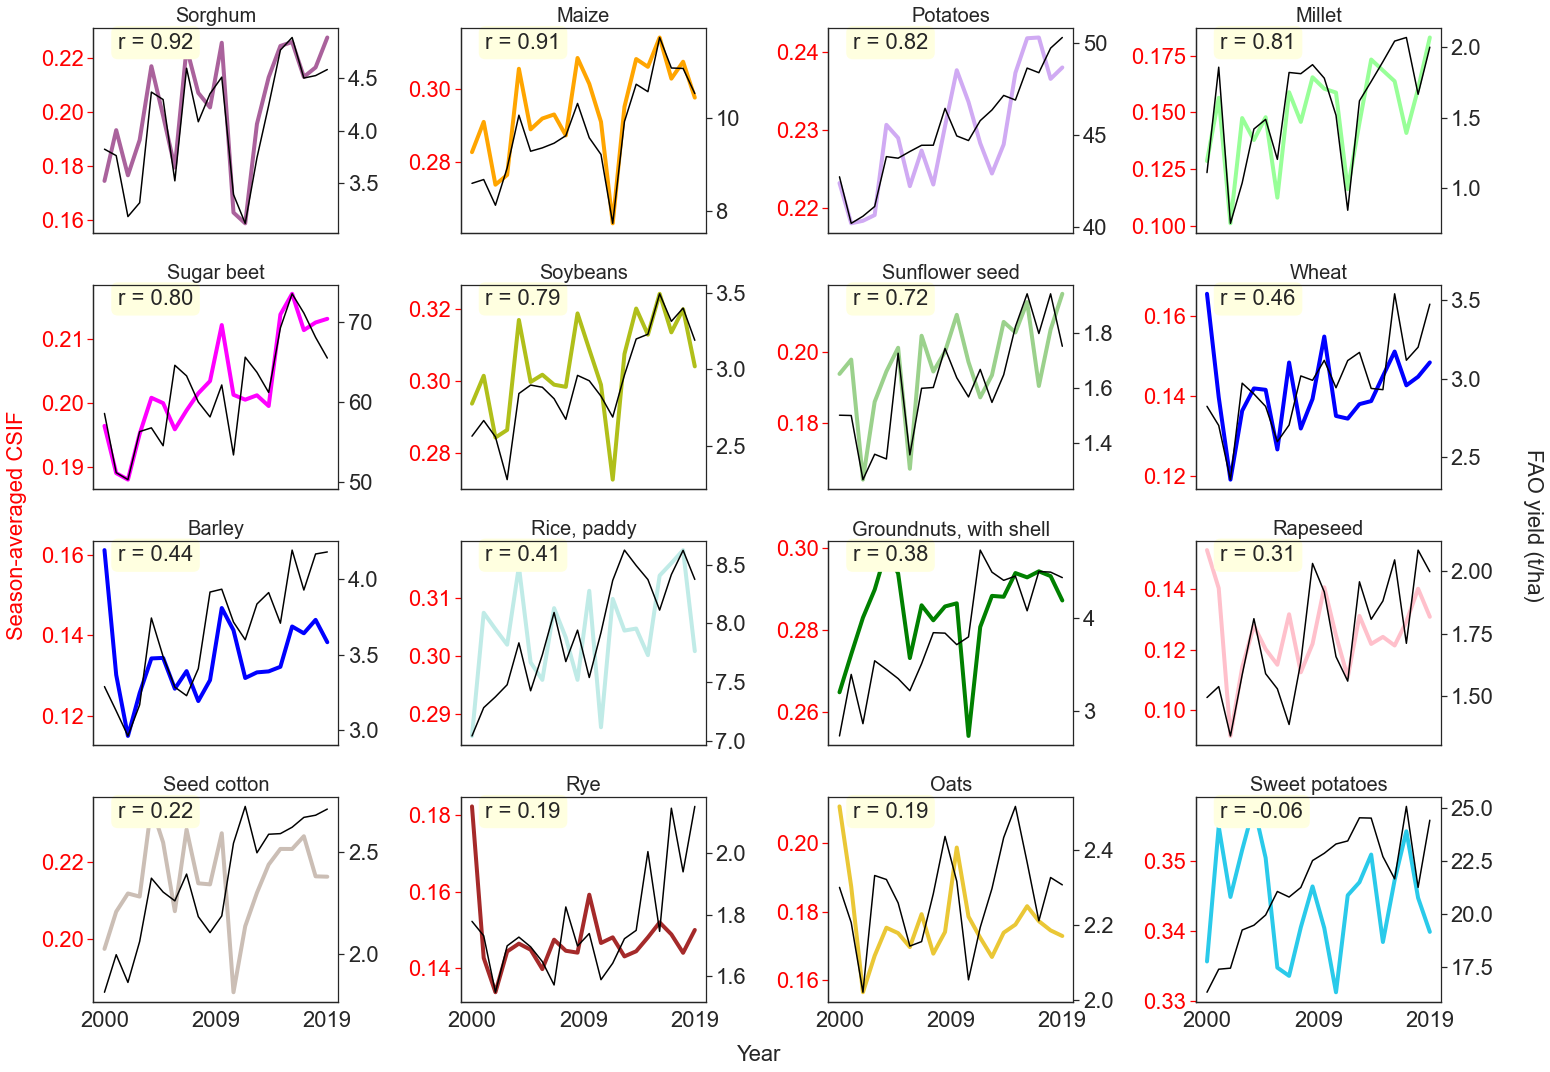

In [28]:
## ordered by correlation R

ugh2=ugh.dropna(subset='yield')

idx, cols = pd.factorize(ugh['whichlag'])
ugh['yield'] = ugh.reindex(cols, axis=1).to_numpy()[np.arange(len(ugh)), idx]
cropnum = len(np.unique(ugh['cropname']))
ugh2['yield'] = ugh2['yield']/10000
colors = ["blue", "green", "orange", "#98ff98", 
      "#eac736", "#d0aaf3", "pink", "#c0ebe7", "brown",
      "#cbbeb5", "#aa629c", "#b0bf1a", "#ff00ff", "#9bd18c",
     "#2acaea"]

def compute_corr(df, var1, var2):
    return df[[var1, var2]].corr().iloc[0, 1]
corrs = ugh2.groupby("cropname").apply(lambda x: compute_corr(x, 'csif', 'yield'))
sorted_r = corrs.sort_values(ascending=False).index

def twin_lineplot(x,y,color,**kwargs):
    ax = plt.twinx()
    sns.lineplot(x=x,y=y,color=color, ax=ax)
    ax.set_ylabel("")
    new_ticks = np.linspace(2000, 2019, 3)
    ax.set_xticks(new_ticks)
    ticks = ax.get_xticks()
    ax.set_xticklabels([f"{int(tick)}" for tick in ticks])

g = sns.FacetGrid(ugh2, col="cropname",hue="cropname",col_order = sorted_r,
                  col_wrap=4, height=4, aspect=1.4, sharey=False, palette= colors)#sns.color_palette("hls", cropnum))
g.map(sns.lineplot, "year", "csif", ci=None, lw=4)

for ax in g.axes.flat:
    ax.tick_params(axis='y', colors='red')
    ax.set_ylabel("", color='red')

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes,
               bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightyellow'))

g.map(corrfunc, "csif", "yield")
g.map(twin_lineplot, 'year', 'yield', color="black")
g.set_axis_labels("", "")
g.set_titles(col_template='{col_name}', size=20)

g.fig.text(0.5, 0.04, 'Year', ha='center', va='center')  # X-axis title
g.fig.text(0.04, 0.5, 'Season-averaged CSIF', ha='center', va='center', rotation='vertical', color="red")  # Y-axis title
g.fig.text(0.98, 0.5, 'FAO yield (t/ha)', ha='center', va='center', rotation='-90')
g.fig.tight_layout(rect=[0.04, 0.04, 0.97, 0.97])  # Adjust the rect parameters as needed


plt.show()
g.savefig("./plots/usa_ts_all.pdf")

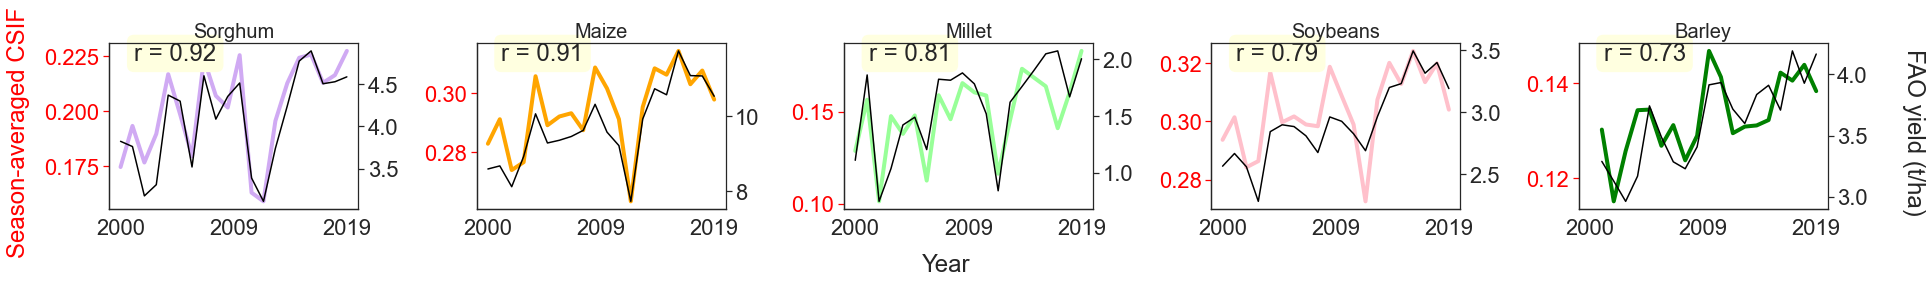

In [38]:
## ordered by correlation R

ugh2 = ugh[ugh['cropname'].isin(['Sorghum', 'Maize', 'Millet', 'Soybeans', 'Barley'])] #, "Oats", "Wheat", "Rice, paddy", "Groundnuts, with shell", "Sweet potatoes"]) ]
ugh2=ugh2.dropna(subset='yield')

idx, cols = pd.factorize(ugh['whichlag'])
ugh['yield'] = ugh.reindex(cols, axis=1).to_numpy()[np.arange(len(ugh)), idx]
cropnum = len(np.unique(ugh['cropname']))
ugh2['yield'] = ugh2['yield']/10000
colors = ["green", "orange", "#98ff98", 
      "#d0aaf3", "pink"]

def compute_corr(df, var1, var2):
    return df[[var1, var2]].corr().iloc[0, 1]
corrs = ugh2.groupby("cropname").apply(lambda x: compute_corr(x, 'csif', 'yield'))
sorted_r = corrs.sort_values(ascending=False).index

def twin_lineplot(x,y,color,**kwargs):
    ax = plt.twinx()
    sns.lineplot(x=x,y=y,color=color, ax=ax)
    ax.set_ylabel("")
    new_ticks = np.linspace(2000, 2019, 3)
    ax.set_xticks(new_ticks)
    ticks = ax.get_xticks()
    ax.set_xticklabels([f"{int(tick)}" for tick in ticks])

g = sns.FacetGrid(ugh2, col="cropname",hue="cropname",col_order = sorted_r,
                  col_wrap=5, height=4, aspect=1.4, sharey=False, palette= colors)#sns.color_palette("hls", cropnum))
g.map(sns.lineplot, "year", "csif", ci=None, lw=4)

for ax in g.axes.flat:
    ax.tick_params(axis='y', colors='red')
    ax.set_ylabel("", color='red')

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes,
               bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightyellow'))

g.map(corrfunc, "csif", "yield")
g.map(twin_lineplot, 'year', 'yield', color="black")
g.set_axis_labels("", "")
g.set_titles(col_template='{col_name}', size=20)

g.fig.text(0.5, 0.04, 'Year', ha='center', va='center')  # X-axis title
g.fig.text(0.04, 0.5, 'Season-averaged CSIF', ha='center', va='center', rotation='vertical', color="red")  # Y-axis title
g.fig.text(0.98, 0.5, 'FAO yield (t/ha)', ha='center', va='center', rotation='-90')
g.fig.tight_layout(rect=[0.04, 0.04, 0.97, 0.97])  # Adjust the rect parameters as needed


plt.show()

g.savefig("./plots/usa_ts_best.pdf")

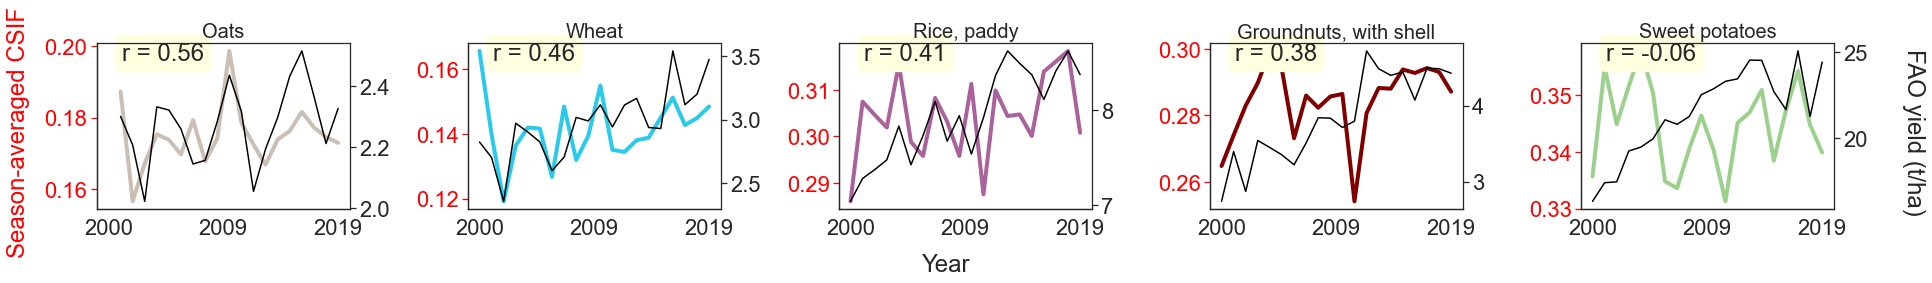

In [41]:
## ordered by correlation R

ugh2 = ugh[ugh['cropname'].isin(["Oats", "Wheat", "Rice, paddy", "Groundnuts, with shell", "Sweet potatoes" ]) ]
ugh2=ugh2.dropna(subset='yield')

idx, cols = pd.factorize(ugh['whichlag'])
ugh['yield'] = ugh.reindex(cols, axis=1).to_numpy()[np.arange(len(ugh)), idx]
cropnum = len(np.unique(ugh['cropname']))
ugh2['yield'] = ugh2['yield']/10000
colors = ["maroon", "#cbbeb5", "#aa629c", "#9bd18c", "#2acaea"]

def compute_corr(df, var1, var2):
    return df[[var1, var2]].corr().iloc[0, 1]
corrs = ugh2.groupby("cropname").apply(lambda x: compute_corr(x, 'csif', 'yield'))
sorted_r = corrs.sort_values(ascending=False).index

def twin_lineplot(x,y,color,**kwargs):
    ax = plt.twinx()
    sns.lineplot(x=x,y=y,color=color, ax=ax)
    ax.set_ylabel("")
    new_ticks = np.linspace(2000, 2019, 3)
    ax.set_xticks(new_ticks)
    ticks = ax.get_xticks()
    ax.set_xticklabels([f"{int(tick)}" for tick in ticks])

g = sns.FacetGrid(ugh2, col="cropname",hue="cropname",col_order = sorted_r,
                  col_wrap=5, height=4, aspect=1.4, sharey=False, palette= colors)#sns.color_palette("hls", cropnum))
g.map(sns.lineplot, "year", "csif", ci=None, lw=4)

for ax in g.axes.flat:
    ax.tick_params(axis='y', colors='red')
    ax.set_ylabel("", color='red')

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes,
               bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightyellow'))

g.map(corrfunc, "csif", "yield")
g.map(twin_lineplot, 'year', 'yield', color="black")
g.set_axis_labels("", "")
g.set_titles(col_template='{col_name}', size=20)

g.fig.text(0.5, 0.04, 'Year', ha='center', va='center')  # X-axis title
g.fig.text(0.04, 0.5, 'Season-averaged CSIF', ha='center', va='center', rotation='vertical', color="red")  # Y-axis title
g.fig.text(0.98, 0.5, 'FAO yield (t/ha)', ha='center', va='center', rotation='-90')
g.fig.tight_layout(rect=[0.04, 0.04, 0.97, 0.97])  # Adjust the rect parameters as needed


plt.show()

g.savefig("./plots/usa_ts_worst.pdf")

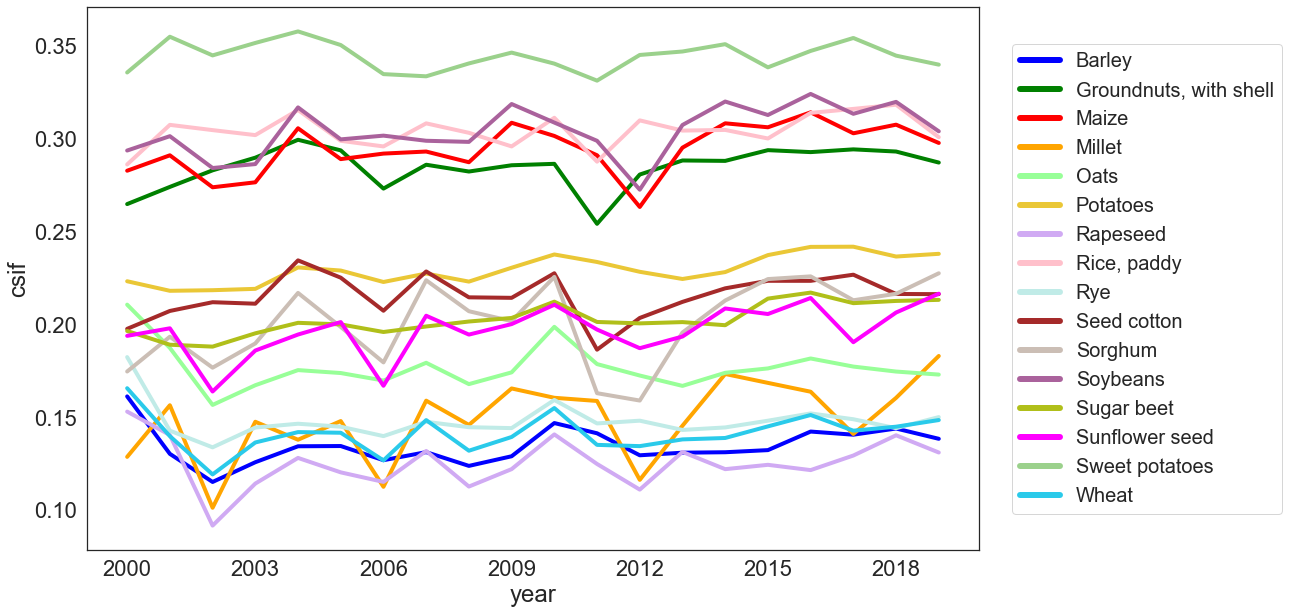

In [31]:
cropnum = len(np.unique(ugh['cropname']))
#colors = sns.color_palette("hls", cropnum)
colors = ["blue", "green", "red", "orange", "#98ff98", 
          "#eac736", "#d0aaf3", "pink", "#c0ebe7", "brown",
          "#cbbeb5", "#aa629c", "#b0bf1a", "#ff00ff", "#9bd18c",
         "#2acaea"]
allcrop = ugh.copy()
plt.figure(figsize=(16, 10))
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(x='year', y='csif', hue='cropname', data=allcrop, palette=colors, lw=4)
ax.set(xticks=list( [2000,2003,2006, 2009, 2012, 2015, 2018]))
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(6)
sns.move_legend(ax, "center right",  bbox_to_anchor=(1.35, 0.5), fontsize=20)
plt.savefig("./plots/usa_spaghetti.pdf")

In [32]:
import os
os.system('say "i love toothless"')

0